In [374]:
import enum
from abc import ABCMeta, abstractmethod

import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plot

"""
参考教程：
  - 
"""
dpi_save = 500

class TopKMethod(enum.Enum):
    MIN = enum.auto()
    MAX = enum.auto()
    
    @staticmethod
    def select(content: str):
        if content.__contains__("↑"):
            return TopKMethod.MAX
        elif content.__contains__("↓"):
            return TopKMethod.MIN
        else:
            raise NotImplementedError
        
    def to_boolean(self):
        return True if self == TopKMethod.MAX else False


class Drawable:
    __meta_class__ = ABCMeta
    @abstractmethod
    def draw(self):
        pass

    
class Header(Drawable):
    def __init__(self, data_frame_all: pd.DataFrame, groups: list[str]):
        self.data_frame = pd.DataFrame(
            [data_frame_all.columns.values],
            index=[data_frame_all.index.name],
            columns=data_frame_all.columns)
        self.groups = groups

    
class Content(Drawable):
    def __init__(self, title: str, data: list[pd.DataFrame]):
        self.title = title
        self.data = data


class Table(Drawable):
    def __init__(self, header: pd.DataFrame, content: list[Content]):
        self.header = header
        self.content = content

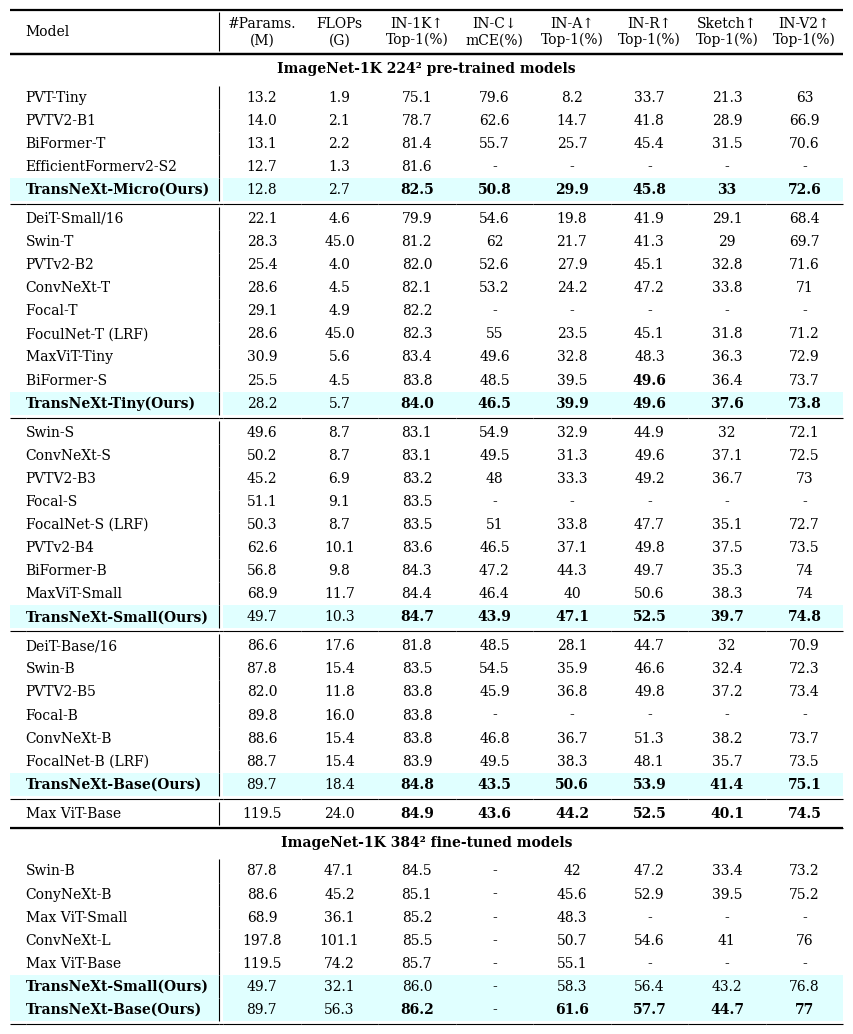

In [394]:

# Vanilla Table
# 参考论文：
#   - 《TransNeXt: Robust Foveal Visual Perception for Vision Transformers》
# == 超参数 ==
font_family = "serif"           # 字体
face_color_ours = "lightcyan"   # 研究数据行的背景颜色
header_pad = 0.2                # 列表头的 padding
header_height = 2.0             # 行表头的高度
header_width = 2.5              # 列表头的宽度
cell_height = 1.2               # 数据单元格的高度
cell_width = 1.0                # 数据单元格的宽度
line_width_bold = 1.6           # 表格粗线宽度
line_width = 0.8                # 表格细线宽度
seperator_height = 0.15         # 表格之间的分割线高度
seperator_width = 0.05


# == 原始数据的读取和处理 ==
data_frame_all = pd.read_excel("datas/TransNeXt Comparison.xlsx")
data_frame_all.set_index("Model", inplace=True)  # 设置索引 index 为 Model 列
data_frame_all.style.background_gradient(cmap="viridis")
# 分析表格数据，将表格按照 NaN 区域分块
data_frames_dict: dict = {
    'header': pd.DataFrame([data_frame_all.columns.values],   # 添加表头
                            index=[data_frame_all.index.name],
                            columns=data_frame_all.columns),
    'content': []
}
i_title = 0
# 表格数据分块
for i in np.arange(len(data_frame_all)):
    row = data_frame_all.iloc[i]    # iloc：index locate，用 index 索引定位；loc：locate，使用标签（column 名）定位
    title_next = row.values[0]
    if math.isnan(title_next):      # 遇到 NaN 区域，即疑似 title 行，分块
        title = row.name
        if  i_title != i:           # 当前行不为标题，则加入改行
            data_frames_dict['content'][-1]['data'].append(data_frame_all.iloc[i_title:i])    # 在每个表格块末尾追加新的表格数据
        if isinstance(title, str):
            data_frames_dict['content'].append({'title': title, 'data': []})
        i_title = i + 1
data_frames_dict['content'][-1]['data'].append(data_frame_all.iloc[i_title:])

num_data_frames = 1 + len(data_frames_dict['content']) + sum([len(content['data']) for content in data_frames_dict['content']])


# == 次超参数 ==
top_columns: list[str] = data_frame_all.columns.values[2:]
top_method = dict([(column, TopKMethod.select(column)) for column in top_columns])
def IsTop(x, data_frame, i_column, top_method=TopKMethod.MAX):
    """
    判断 x 是否为同列 data_frame 中的最大值，或最小值
    """
    # 移除数据列中的无效数据，比如 "-", "N/A", "nan", "_" 等，并保留数值型数据
    valid_values = []
    for value in data_frame.iloc[:, i_column].values:
        if isinstance(value, (int, float)) and not math.isnan(value):
            valid_values.append(value)
        elif isinstance(value, str):
            try:
                valid_values.append(float(value))   # TODO: 有没有 float 到 str 的 try_parse(str) 的方法
            except Exception as e:
                pass
    if len(valid_values) <= 0:
        return False
    
    # 计算 Top K 值
    top = max(valid_values) if top_method == TopKMethod.MAX else min(valid_values)
    if str(top) == str(x):
        return True
    return False


# == 创建图表 ==
# 获取表格高度信息
height_dict = {
    'header': header_height + 2 * seperator_height,
    'content': []
}
for content in data_frames_dict['content']:
    height_dict['content'].append({'title': cell_height + 2 * seperator_height, 'data': []})
    for data_frame in content['data']:
        height_dict['content'][-1]['data'].append(len(data_frame) * cell_height + 2 * seperator_height)
        
height_ratios = [header_height + 2 * seperator_height]                              # 表头
for content in data_frames_dict['content']:
    height_ratios.append(cell_height + 2 * seperator_height)                        # 表格标题
    for data_frame in content['data']:
        height_ratios.append(len(data_frame) * cell_height + 2 * seperator_height)  # 表格内容
fig_height = sum(height_ratios) / 4
# 获取表格宽度信息
widths = [header_pad] + [header_width] + [seperator_width] + [cell_width] * len(data_frame_all.columns)
fig_width = sum(widths)
# 根据高宽创建图表
fig, axes = plot.subplots(num_data_frames, 1, height_ratios=height_ratios,
                          figsize=(fig_width, fig_height), dpi=100)
plot.subplots_adjust(hspace=0)  # 调整所有子图 height space 间隔为 0


# == 绘制对所有块的图表 ==
widths = list(np.multiply(widths, 1/ sum(widths)))
edge_color_ours = {'L': face_color_ours, 'R': "black", 'T': face_color_ours, 'B': face_color_ours}
class Index:
    def __init__(self):
        self.i = 0
    
    def increase(self):
        self.i += 1
i_ax = Index()
def pad_dataframe(data_frame: pd.DataFrame):
    """
    将 dataframe 上下各插入一个空行，作为 padding；再在第一列之前插入 index 列，作为表头
    """
    data_frame.insert(0, "__Padding__", data_frame.index)       # 插入一列空列作为 padding
    data_frame.insert(1, "Model", data_frame.index)             # 插入一列 Model 列作为表头，方便后续宽度设置
    data_frame.insert(2, "__Seperator__", data_frame.index)     # 插入一列空列作为分割线
    empty_row = pd.DataFrame([[np.nan] * len(data_frame.columns)], columns=data_frame.columns)
    data_frame = pd.concat([empty_row, data_frame, empty_row])  # 在第一行和最后一行插入空行
    rows = len(data_frame.index)
    cols = len(data_frame.columns)
    return data_frame, rows, cols
def get_axes():
    """
    按顺序获取 axes
    """
    ax: plot.Axes = axes[i_ax.i]
    i_ax.increase()
    return ax
def init_table(data_frame: pd.DataFrame, ax: plot.Axes) -> matplotlib.table.Table:
    """
    创建表格模板
    """
    ax.axis("off")
    table: matplotlib.table.Table = ax.table(
        cellText=data_frame.values,
        cellLoc="center",
        bbox=[0, 0, 1, 1],
        edges="open")
    table.set_fontsize(10)
    return table
# 绘制 header
def draw_header():
    data_frame, rows, cols = pad_dataframe(data_frames_dict['header'])
    ax: plot.Axes = get_axes()
    
    table = init_table(data_frame, ax)
    
    # 设置单元格宽高
    for i in np.arange(rows):
        for j in np.arange(cols):
            table[i, j].set(width=widths[j], height=height_dict['header'])  # 设置列宽和行高
            table[i, j].set_text_props(fontfamily=font_family)
            table[i, j].PAD = 0
    # 设置单元格其他属性
    for i in np.arange(rows):       # 设置每行属性
        # 设置 padding 属性
        cell_padding: matplotlib.table.Cell = table[i, 0]
        cell_padding.get_text().set_text("")                        # padding 单元格内容为空
        # 设置表头属性
        cell_header: matplotlib.table.Cell = table[i, 1]
        cell_header.set_text_props(horizontalalignment="left")      # 表头左对齐
        # 设置分割线属性
        cell_seperator: matplotlib.table.Cell = table[i, 2]
        cell_seperator.visible_edges += "L"                         # 分割线边框为右边框
        cell_seperator.get_text().set_text("")                      # 分割线单元格内容为空
        cell_seperator.set(linewidth=line_width)  # 设置列宽几乎为 0
        # 设置其他单元格属性
        text: matplotlib.text.Text = cell_header.get_text()
        if text.get_text().lower() == "nan":
            if i == 0:
                for j in np.arange(cols):              # 该行所有单元格的边颜色
                    table[i, j].get_text().set_text("")
                    table[i, j].set(edgecolor="black", linewidth=line_width_bold)
                    table[i, j].visible_edges = "T"           # "上"边框
                    table[i, j].set(height=seperator_height)
            elif i == rows - 1:
                for j in np.arange(cols):              # 该行所有单元格的边颜色
                    table[i, j].get_text().set_text("")
                    table[i, j].set(edgecolor="black", linewidth=line_width_bold)
                    table[i, j].visible_edges = "B"           # "下"边框
                    table[i, j].set(height=seperator_height)
draw_header()
    
# 绘制表格快（title + data）
def draw_content():
    for content, height in zip(data_frames_dict['content'], height_dict['content']):
        # 绘制 title
        title: str = content['title']
        ax: plot.Axes = get_axes()
        # title 只有一格，所以使用 [0, 0] 访问
        table = init_table(pd.DataFrame([title]), ax)
        table[0, 0].set_text_props(weight="bold", fontfamily=font_family)
        table[0, 0].set(edgecolor="black", linewidth=line_width_bold, height=height['title'])  # 设置上边框属性
        table[0, 0].visible_edges = "T"
        
        # 绘制 data
        num_data = len(content['data'])
        for i_frame in np.arange(0, num_data):
            data_frame, rows, cols = pad_dataframe(content['data'][i_frame])
            ax: plot.Axes = get_axes()
            
            table = init_table(data_frame, ax)
            
            # 设置单元格宽高
            for i in np.arange(rows):
                for j in np.arange(cols):
                    table[i, j].set(width=widths[j], height=cell_height)    # 设置列宽和行高
                    table[i, j].set_text_props(fontfamily=font_family)
                    table[i, j].PAD = 0     # 设置文字到单元格的 padding，只能大写，不能小写    
            # 设置排序单元颜色
            for j in np.arange(3, cols):
                for i in np.arange(rows):
                    column_name = data_frame.columns[j]
                    if not list(top_method.keys()).__contains__(column_name):
                        continue
                        
                    is_top = IsTop(table[i, j].get_text().get_text(), data_frame, j, 
                                  top_method=topk_method[column_name])
                    if is_top:
                        table[i, j].set_text_props(fontweight="bold")
            # 设置单元其他属性
            for i in np.arange(rows):       # 设置每行属性
                # 设置 padding 属性
                cell_padding: matplotlib.table.Cell = table[i, 0]
                cell_padding.get_text().set_text("")                        # padding 单元格内容为空
                # 设置表头属性
                cell_header: matplotlib.table.Cell = table[i, 1]
                cell_header.set_text_props(horizontalalignment="left")      # 表头左对齐
                # 设置分割线属性
                cell_seperator: matplotlib.table.Cell = table[i, 2]
                cell_seperator.visible_edges += "L"                         # 分割线边框为右边框
                cell_seperator.get_text().set_text("")                      # 分割线单元格内容为空
                cell_seperator.set(linewidth=line_width)  # 设置列宽几乎为 0
                # 设置其他单元格属性
                text: matplotlib.text.Text = cell_header.get_text()
                if text.get_text().lower().__contains__("ours"):
                    cell_header.set_text_props(weight="bold")   # 表头带 Ours 的文字字体加粗
                    for j in np.arange(cols):                   # 设置该行所有单元格的背景颜色
                        if table[i, j] == cell_seperator:
                            continue
                        table[i, j].visible_edges = "closed"
                        table[i, j].set(edgecolor=face_color_ours, facecolor=face_color_ours, linewidth=0)
                elif text.get_text().lower() != "nan":     # 不是空行就不进行下面其余操作
                    continue
                    
                if i == 0:
                    for j in np.arange(cols):              # 第一行所有单元格为空白
                        table[i, j].get_text().set_text("")
                        table[i, j].visible_edges = "open"
                        table[i, j].set(height=seperator_height)
                elif i == rows - 1:
                    for j in np.arange(cols):              # 最后一行所有单元格都有下边框
                        _line_width = line_width if i_frame != num_data - 1 else line_width_bold
                        table[i, j].get_text().set_text("")
                        table[i, j].set(edgecolor="black", linewidth=line_width, height=seperator_height)
                        table[i, j].visible_edges = "B"
draw_content()

plot.savefig("./figures/Vanilla Table.png", dpi=dpi_save) # 保存图表
plot.show()

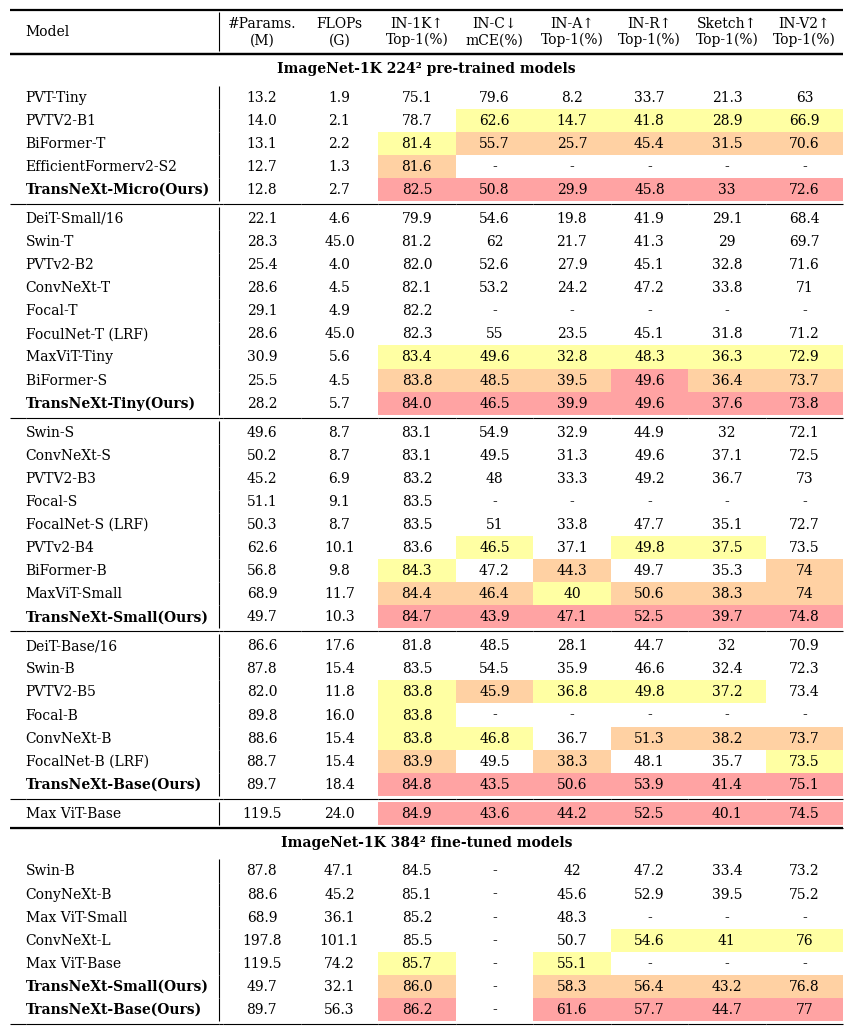

In [391]:

# TopK Colormap Table
# 参考论文：
#   - 《TransNeXt: Robust Foveal Visual Perception for Vision Transformers》
# == 超参数 ==
font_family = "serif"           # 字体
face_color_ours = "lightcyan"   # 研究数据行的背景颜色
header_pad = 0.2                # 列表头的 padding
header_height = 2.0             # 行表头的高度
header_width = 2.5              # 列表头的宽度
cell_height = 1.2               # 数据单元格的高度
cell_width = 1.0                # 数据单元格的宽度
line_width_bold = 1.6           # 表格粗线宽度
line_width = 0.8                # 表格细线宽度
seperator_height = 0.15         # 表格之间的分割线高度
seperator_width = 0.05


# == 原始数据的读取和处理 ==
data_frame_all = pd.read_excel("datas/TransNeXt Comparison.xlsx")
data_frame_all.set_index("Model", inplace=True)  # 设置索引 index 为 Model 列
data_frame_all.style.background_gradient(cmap="viridis")
# 分析表格数据，将表格按照 NaN 区域分块
data_frames_dict: dict = {
    'header': pd.DataFrame([data_frame_all.columns.values],   # 添加表头
                            index=[data_frame_all.index.name],
                            columns=data_frame_all.columns),
    'content': []
}
i_title = 0
# 表格数据分块
for i in np.arange(len(data_frame_all)):
    row = data_frame_all.iloc[i]    # iloc：index locate，用 index 索引定位；loc：locate，使用标签（column 名）定位
    title_next = row.values[0]
    if math.isnan(title_next):      # 遇到 NaN 区域，即疑似 title 行，分块
        title = row.name
        if  i_title != i:           # 当前行不为标题，则加入改行
            data_frames_dict['content'][-1]['data'].append(data_frame_all.iloc[i_title:i])    # 在每个表格块末尾追加新的表格数据
        if isinstance(title, str):
            data_frames_dict['content'].append({'title': title, 'data': []})
        i_title = i + 1
data_frames_dict['content'][-1]['data'].append(data_frame_all.iloc[i_title:])

num_data_frames = 1 + len(data_frames_dict['content']) + sum([len(content['data']) for content in data_frames_dict['content']])


# == 次超参数 ==
topk_columns: list[str] = data_frame_all.columns.values[2:]
k = 3
topk_method = dict([(column, TopKMethod.select(column)) for column in topk_columns])

# == 颜色映射 ==
# 自定义颜色映射，参考：https://blog.csdn.net/mr_cat123/article/details/78638491
color_offset = 0
cmap = plot.cm.get_cmap("autumn") 
# 定义颜色映射函数，用于绘制 Top K 值的颜色，如果 x 在 Top K 值中，则返回对应颜色，否则返回白色
def TopK_cmap(x, data_frame, i_column, color_reverse=True, topk_reverse=False):
    """
    Args:
        x: 输入单元格的数据
        data_frame: 输入表格数据
        i_column: 单元格数据 x 所在列索引
        color_reverse: topk 的颜色反转，比如 False 时 [1, 2, 3] 对应 ['yellow', 'orange', 'red']，反转后对应为 ['red', 'orange', 'yellow']
        topk_reverse: topk 的排序反转，比如 False 时 [1, 2, 3, 4, 5] 的 topk(3) 为 [1, 2, 3]，反转后为 [5, 4, 3]
    """
    # 移除数据列中的无效数据，比如 "-", "N/A", "nan", "_" 等，并保留数值型数据
    valid_values = []
    for value in data_frame.iloc[:, i_column].values:
        if isinstance(value, (int, float)) and not math.isnan(value):
            valid_values.append(value)
        elif isinstance(value, str):
            try:
                valid_values.append(float(value))   # TODO: 有没有 float 到 str 的 try_parse(str) 的方法
            except Exception as e:
                pass
    # 计算 Top K 值
    topk = sorted(valid_values, reverse=topk_reverse)[:k]
    for j, value in enumerate(topk):
        position = j if color_reverse else k - j - 1
        if str(value) == str(x):
            return cmap((position + color_offset) / (k + color_offset * 2 - 1))
    return "white"


# == 创建图表 ==
# 获取表格高度信息
height_dict = {
    'header': header_height + 2 * seperator_height,
    'content': []
}
for content in data_frames_dict['content']:
    height_dict['content'].append({'title': cell_height + 2 * seperator_height, 'data': []})
    for data_frame in content['data']:
        height_dict['content'][-1]['data'].append(len(data_frame) * cell_height + 2 * seperator_height)
        
height_ratios = [header_height + 2 * seperator_height]                              # 表头
for content in data_frames_dict['content']:
    height_ratios.append(cell_height + 2 * seperator_height)                        # 表格标题
    for data_frame in content['data']:
        height_ratios.append(len(data_frame) * cell_height + 2 * seperator_height)  # 表格内容
fig_height = sum(height_ratios) / 4
# 获取表格宽度信息
widths = [header_pad] + [header_width] + [seperator_width] + [cell_width] * len(data_frame_all.columns)
fig_width = sum(widths)
# 根据高宽创建图表
fig, axes = plot.subplots(num_data_frames, 1, height_ratios=height_ratios,
                          figsize=(fig_width, fig_height), dpi=100)
plot.subplots_adjust(hspace=0)  # 调整所有子图 height space 间隔为 0


# == 绘制对所有块的图表 ==
widths = list(np.multiply(widths, 1/ sum(widths)))
edge_color_ours = {'L': face_color_ours, 'R': "black", 'T': face_color_ours, 'B': face_color_ours}
class Index:
    def __init__(self):
        self.i = 0
    
    def increase(self):
        self.i += 1
i_ax = Index()
def pad_dataframe(data_frame: pd.DataFrame):
    """
    将 dataframe 上下各插入一个空行，作为 padding；再在第一列之前插入 index 列，作为表头
    """
    data_frame.insert(0, "__Padding__", data_frame.index)       # 插入一列空列作为 padding
    data_frame.insert(1, "Model", data_frame.index)             # 插入一列 Model 列作为表头，方便后续宽度设置
    data_frame.insert(2, "__Seperator__", data_frame.index)     # 插入一列空列作为分割线
    empty_row = pd.DataFrame([[np.nan] * len(data_frame.columns)], columns=data_frame.columns)
    data_frame = pd.concat([empty_row, data_frame, empty_row])  # 在第一行和最后一行插入空行
    rows = len(data_frame.index)
    cols = len(data_frame.columns)
    return data_frame, rows, cols
def get_axes():
    """
    按顺序获取 axes
    """
    ax: plot.Axes = axes[i_ax.i]
    i_ax.increase()
    return ax
def init_table(data_frame: pd.DataFrame, ax: plot.Axes) -> matplotlib.table.Table:
    """
    创建表格模板
    """
    ax.axis("off")
    table: matplotlib.table.Table = ax.table(
        cellText=data_frame.values,
        cellLoc="center",
        bbox=[0, 0, 1, 1],
        edges="open")
    table.set_fontsize(10)
    return table
# 绘制 header
def draw_header():
    data_frame, rows, cols = pad_dataframe(data_frames_dict['header'])
    ax: plot.Axes = get_axes()
    
    table = init_table(data_frame, ax)
    
    # 设置单元格宽高
    for i in np.arange(rows):
        for j in np.arange(cols):
            table[i, j].set(width=widths[j], height=height_dict['header'])  # 设置列宽和行高
            table[i, j].set_text_props(fontfamily=font_family)
            table[i, j].PAD = 0
    # 设置单元格其他属性
    for i in np.arange(rows):       # 设置每行属性
        # 设置 padding 属性
        cell_padding: matplotlib.table.Cell = table[i, 0]
        cell_padding.get_text().set_text("")                        # padding 单元格内容为空
        # 设置表头属性
        cell_header: matplotlib.table.Cell = table[i, 1]
        cell_header.set_text_props(horizontalalignment="left")      # 表头左对齐
        # 设置分割线属性
        cell_seperator: matplotlib.table.Cell = table[i, 2]
        cell_seperator.visible_edges += "L"                         # 分割线边框为右边框
        cell_seperator.get_text().set_text("")                      # 分割线单元格内容为空
        cell_seperator.set(linewidth=line_width)  # 设置列宽几乎为 0
        # 设置其他单元格属性
        text: matplotlib.text.Text = cell_header.get_text()
        if text.get_text().lower() == "nan":
            if i == 0:
                for j in np.arange(cols):              # 该行所有单元格的边颜色
                    table[i, j].get_text().set_text("")
                    table[i, j].set(edgecolor="black", linewidth=line_width_bold)
                    table[i, j].visible_edges = "T"           # "上"边框
                    table[i, j].set(height=seperator_height)
            elif i == rows - 1:
                for j in np.arange(cols):              # 该行所有单元格的边颜色
                    table[i, j].get_text().set_text("")
                    table[i, j].set(edgecolor="black", linewidth=line_width_bold)
                    table[i, j].visible_edges = "B"           # "下"边框
                    table[i, j].set(height=seperator_height)
draw_header()
    
# 绘制表格快（title + data）
def draw_content():
    for content, height in zip(data_frames_dict['content'], height_dict['content']):
        # 绘制 title
        title: str = content['title']
        ax: plot.Axes = get_axes()
        # title 只有一格，所以使用 [0, 0] 访问
        table = init_table(pd.DataFrame([title]), ax)
        table[0, 0].set_text_props(weight="bold", fontfamily=font_family)
        table[0, 0].set(edgecolor="black", linewidth=line_width_bold, height=height['title'])  # 设置上边框属性
        table[0, 0].visible_edges = "T"
        
        # 绘制 data
        num_data = len(content['data'])
        for i_frame in np.arange(0, num_data):
            data_frame, rows, cols = pad_dataframe(content['data'][i_frame])
            ax: plot.Axes = get_axes()
            
            table = init_table(data_frame, ax)
            
            # 设置单元格宽高
            for i in np.arange(rows):
                for j in np.arange(cols):
                    table[i, j].set(width=widths[j], height=cell_height)    # 设置列宽和行高
                    table[i, j].set_text_props(fontfamily=font_family)
                    table[i, j].PAD = 0     # 设置文字到单元格的 padding，只能大写，不能小写
            # 设置排序单元颜色
            for j in np.arange(3, cols):
                for i in np.arange(rows):
                    column_name = data_frame.columns[j]
                    if not list(topk_method.keys()).__contains__(column_name):
                        continue
                        
                    color = TopK_cmap(table[i, j].get_text().get_text(), data_frame, j,
                                      topk_reverse=topk_method[column_name].to_boolean())
                    table[i, j].visible_edges = "closed"
                    table[i, j].set(edgecolor=color, facecolor=color, linewidth=0)
                    if color != "white":
                        table[i, j].set(alpha=0.36)
            # 设置单元其他属性
            for i in np.arange(rows):       # 设置每行属性
                # 设置 padding 属性
                cell_padding: matplotlib.table.Cell = table[i, 0]
                cell_padding.get_text().set_text("")                        # padding 单元格内容为空
                # 设置表头属性
                cell_header: matplotlib.table.Cell = table[i, 1]
                cell_header.set_text_props(horizontalalignment="left")      # 表头左对齐
                # 设置分割线属性
                cell_seperator: matplotlib.table.Cell = table[i, 2]
                cell_seperator.visible_edges += "L"                         # 分割线边框为右边框
                cell_seperator.get_text().set_text("")                      # 分割线单元格内容为空
                cell_seperator.set(linewidth=line_width)  # 设置列宽几乎为 0
                # 设置其他单元格属性
                text: matplotlib.text.Text = cell_header.get_text()
                if text.get_text().lower().__contains__("ours"):
                    cell_header.set_text_props(weight="bold")   # 表头带 Ours 的文字字体加粗
                elif text.get_text().lower() != "nan":     # 不是空行就不进行下面其余操作
                    continue
                    
                if i == 0:
                    for j in np.arange(cols):              # 第一行所有单元格为空白
                        table[i, j].get_text().set_text("")
                        table[i, j].visible_edges = "open"
                        table[i, j].set(height=seperator_height)
                elif i == rows - 1:
                    for j in np.arange(cols):              # 最后一行所有单元格都有下边框
                        _line_width = line_width if i_frame != num_data - 1 else line_width_bold
                        table[i, j].get_text().set_text("")
                        table[i, j].set(edgecolor="black", linewidth=line_width, height=seperator_height)
                        table[i, j].visible_edges = "B"
draw_content()

plot.savefig("./figures/TopK Colormap Table.png", dpi=dpi_save) # 保存图表
plot.show()